# Generating training data

In this notebook we generate the data used to train the quantum reservoir computing models with different noise models. We study the LiH molecule. We map the electronic Hamiltonian to a $n-$qubit space, and perform exact diagonalization to obtain the ground state, and the first two excited energies. The ground state will be the input to the quantum machine learning model, and the the excited energies will be the targets to be predicted by the model. 

In [ ]:
!pip install pyscf

In [ ]:
!pip install git+https://github.com/quantumlib/OpenFermion-PySCF@master#egg=openfermionpyscf

In [3]:
try:
    import openfermion
except ImportError:
    !pip install git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
cd /content/gdrive/My Drive/Colab Notebooks/PhD/quantum_computing

/content/gdrive/My Drive/Colab Notebooks/PhD/quantum_computing


In [9]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf

from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_ground_state, get_sparse_operator,eigenspectrum

import numpy as np
import scipy.linalg
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# LiH molecule

For LiH in the STO-3G basis, we consider $\{1s, 2s, 2p_x, 2p_y, 2p_z\}$ functions for Li, and a single $1s$ orbital for H. This gives a total of 12 spin
orbitals. 

## Qubit Hamiltonian

## Second quantization

To obtain the second quantization Hamiltonian we project the Hamiltonian onto the $M$ basis wave functions $\{\phi_p(x_i)\}_p$ where $x_i$ is the spatial and spin coordinate of the ith electron $x_i = (r_i, 𝝈$).  We consider many-electron wave functions that must be antisymmetric under the exchange of any two electrons. To write down a Slater determinant we need only to indicate which spin orbitals are occupied by electrons. 

This facilitates the introduction of a convenient shorthand for Slater determinants.
$$
\psi(x_0, \cdots, x_N) = |f_{M-1}, \cdots, f_0> = |f>
$$

where $f_p=1$ when $\phi_p$ is occupied  and where $f_p=0$ when $\phi_p$ is empty. Electrons are excited into the single-electron spin orbitals by the fermionic creation operators $a^\dagger_p$. They are deexcited by the annihilation operators $a_p$. The second quantized form of the electronic
Hamiltonian is
$$
H = \sum_{p,q} h_{pq} a^\dagger_p a_q + \frac{1}{2}\sum_{p,q,r,s} h_{pqrs} a_p^\dagger a_q ^\dagger a_r a_s
$$


## Jordan-Wigner transformation

From the second-quantized Hamiltonian, we use the Jordan-Wigner transformation to map the Hamiltonian to the qubit space. The Jordan-Wigner (JW) transformation stores the occupation number of a spin orbital in the $|0>$ or $|1>$ state of a qubit. The qubit mappings of the operators preserve these features and are given by

$$
a_p = Q_p \otimes Z_{p-1} \otimes \cdots \otimes Z_0
$$
$$
a_p^\dagger = Q_p^\dagger \otimes Z_{p-1} \otimes \cdots \otimes Z_0
$$

where $Q_p = 1/2(X+iY)$, $Q_p^\dagger = (1/2)(X-iY)$. Using
the JW encoding, the second quantized fermionic Hamiltonian
is mapped to a linear combination of products of single-qubit
Pauli operators

$$
H = \sum_j h_j \prod_i \sigma_i^j
$$

where $h_j$ is a real scalar coefficient, $\sigma_i^j$ represents one of the
operators I, X, Y or Z, $i$ denotes which qubit the operator acts on, and $j$ denotes the term in the Hamiltonian.

Now we obtain the qubit Hamiltonian for the LiH molecule, for different values of H-Li distances, $r \in [0.5,3.5]$ A. 

In [12]:
# LiH molecule parameters
bond_lengths = np.arange(0.5,3.5,0.01)
size = bond_lengths.shape[0]
basis = 'sto-3g'
multiplicity = 1

# Molecule optim9ization parameters
run_scf = 1 # SCF = Self-consistent field (Hartree-Fock & DFT)
run_mp2 = 1 # MP2 = Second-order Møller–Plesset perturbation (post-Hartree–Fock method)
run_cisd = 0 # Cisd = singles and doubles configuration interaction (similar to mp2)
run_ccsd = 0 # ccsd = Coupled-cluster (similar to mp2)
run_fci = 1 # fci = full configuration interaction
delete_input = False
delete_output = False

# Store results
noons = np.zeros((size, 6))
spectrums = np.zeros((size, 5))
ground_states = np.zeros((size, 256))
print('Size ', size)

Size  300


We have defined 300 molecules with different bond lenght. Now we calculate the second-quantized Hamiltonian and then perform the JW transformation. Finally, we extract the ground state and excited energies by exact diagonalization. 




In [13]:
bond_length = bond_lengths[0]
geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., bond_length))]
# Generate and populate instance of MolecularData.
molecule = MolecularData(geometry, basis, multiplicity, description=str(bond_length))

# Run pyscf.
molecule = run_pyscf(molecule, run_scf=run_scf, run_mp2=run_mp2,
                    run_cisd=run_cisd, run_ccsd=run_ccsd, run_fci=run_fci)

rdm = molecule.get_molecular_rdm(use_fci=True)
rdm1 = rdm.one_body_tensor
noon,_= np.linalg.eig(rdm1)
print(noon)

[1.99934300e+00 1.93215657e+00 2.18032237e-02 9.80220380e-04
 2.28584907e-02 2.28584907e-02]


It is sometimes the case that certain orbitals are very likely to be either occupied or virtual in all Slater determinants in the wave function. As calculating the ground state energy is essentially a question of distributing electrons among orbitals, we can simplify our calculation by using this information. Specifically, we are able to remove spin orbitals from the calculation if their expected occupation number is close to 0 or 1. Here, we check that the first orbital (corresponding to $a_0,a_1$) is very close to 2 and the 4rd orbital ($a_6,a_7$) is close to 0.

In [10]:
for i in range(size):
  bond_length = bond_lengths[i]
  geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., bond_length))]
  # Generate and populate instance of MolecularData.
  molecule = MolecularData(geometry, basis, multiplicity, description=str(bond_length))

  # Run pyscf.
  molecule = run_pyscf(molecule, run_scf=run_scf, run_mp2=run_mp2,
                      run_cisd=run_cisd, run_ccsd=run_ccsd, run_fci=run_fci)

  rdm = molecule.get_molecular_rdm(use_fci=True)
  rdm1 = rdm.one_body_tensor
  noon,_= np.linalg.eig(rdm1)
  noons[i] = noon

  # Hamiltonian parameters.
  occupied_indices = [0] # by pairs a0, a1
  active_indices = [1,2,4,5]
  # occupied_indices(list): A list of spatial orbital indices indicating which orbitals should be considered doubly occupied.
  # active_indices(list): A list of spatial orbital indices indicating which orbitals should be considered active.

  # Get the Hamiltonian in an active space.
  # Output the second quantized Hamiltonian coefficients.
  molecular_hamiltonian = molecule.get_molecular_hamiltonian(occupied_indices=occupied_indices, active_indices=active_indices)

  # Map operator to fermions and qubits.
  fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
  qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
  qubit_hamiltonian.compress()

  # Get sparse operator and ground state energy.
  sparse_hamiltonian = get_sparse_operator(qubit_hamiltonian)
  spectrum, all_states = scipy.linalg.eigh(sparse_hamiltonian.toarray())
  ground_energy, ground_state = spectrum[0], all_states[:,0]
  spectrum = np.unique(spectrum.round(6))
  spectrums[i] = spectrum[:5]
  ground_states[i] = ground_state

  print('{}/{} At bond length of {} angstrom, molecular LiH has:'.format(i, size, bond_length))
  print('Spectrum energies', spectrum[:5])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


0/300 At bond length of 0.5 angstrom, molecular LiH has:
Spectrum energies [-7.043924 -7.028137 -7.004725 -6.985484 -6.96791 ]
1/300 At bond length of 0.51 angstrom, molecular LiH has:
Spectrum energies [-7.076119 -7.058403 -7.034622 -7.015799 -6.997421]
2/300 At bond length of 0.52 angstrom, molecular LiH has:
Spectrum energies [-7.107045 -7.087336 -7.063169 -7.044681 -7.025614]
3/300 At bond length of 0.53 angstrom, molecular LiH has:
Spectrum energies [-7.136767 -7.115026 -7.090456 -7.072237 -7.052576]
4/300 At bond length of 0.54 angstrom, molecular LiH has:
Spectrum energies [-7.165345 -7.14155  -7.116562 -7.09856  -7.078384]
5/300 At bond length of 0.55 angstrom, molecular LiH has:
Spectrum energies [-7.192836 -7.166981 -7.141558 -7.123734 -7.103111]
6/300 At bond length of 0.56 angstrom, molecular LiH has:
Spectrum energies [-7.219289 -7.191382 -7.165511 -7.147834 -7.126818]
7/300 At bond length of 0.5700000000000001 angstrom, molecular LiH has:
Spectrum energies [-7.244753 -7.2

## Plot energy curves

The next figure shows the energy curves for the ground, first and second excited states.

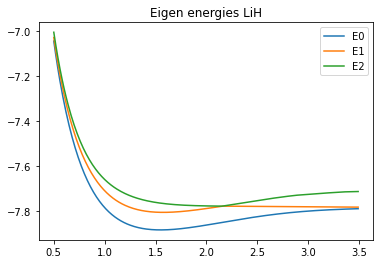

In [11]:
plt.plot(bond_lengths, spectrums[:,0], label='E0')
plt.plot(bond_lengths, spectrums[:,1], label='E1')
plt.plot(bond_lengths, spectrums[:,2], label='E2')
plt.title('Eigen energies LiH')
plt.legend()
plt.show()

In [ ]:
with open('../training_data/spectrums_LiH.npy', 'wb') as f:
  np.save(f, spectrums, allow_pickle=True)

with open('../training_data/bond_lengths_LiH.npy', 'wb') as f:
  np.save(f, bond_lengths, allow_pickle=True)

with open('../training_data/ground_states_LiH.npy', 'wb') as f:
  np.save(f, ground_states, allow_pickle=True)

## Generate target

The target of the model is

$$
y(t) = (\Delta E_1(r), \Delta E_2(r))
$$

We normalize $y(r)$ so that it lies between 0 and 1 for all the data.

In [ ]:
y = np.zeros((size, 2))
y[:,0] = spectrums[:,1] - spectrums[:,0]
y[:,1] = spectrums[:,2] - spectrums[:,0]